# Learnsync ML use case implementation

In [12]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew
from matplotlib_venn import venn3
from scipy.stats import shapiro
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

## Data source
[Time Management and Productivity Insights](https://www.kaggle.com/datasets/hanaksoy/time-management-and-productivity-insights/data)

In [2]:
path = "../data/Time Management and Productivity Insights.csv"
data = pd.read_csv(path)
data.sample(5)

,User ID,Age,Daily Work Hours,Daily Leisure Hours,Daily Exercise Minutes,Daily Sleep Hours,Productivity Score,Screen Time (hours),Commute Time (hours)
1,2,32,4.8,3.5,6,8.8,69,7.2,1.9
2,3,52,3.4,2.1,75,7.2,68,3.3,2.0
57,58,29,4.4,6.2,100,8.0,90,5.0,0.7
78,79,32,7.5,3.7,60,7.0,85,5.9,1.8
54,55,55,8.6,3.4,70,6.7,94,6.2,1.9


In [3]:
data.describe()

,User ID,Age,Daily Work Hours,Daily Leisure Hours,Daily Exercise Minutes,Daily Sleep Hours,Productivity Score,Screen Time (hours),Commute Time (hours)
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,43.000000,39.529412,7.021176,4.264706,64.611765,7.111765,82.176471,5.774118,1.584706
std,24.681302,12.416951,1.523396,1.157348,27.006654,0.783523,10.250640,1.225343,0.534190
min,1.000000,18.000000,3.400000,1.700000,6.000000,5.200000,55.000000,2.800000,0.600000
25%,22.000000,29.000000,5.900000,3.400000,45.000000,6.600000,74.000000,4.900000,1.200000
50%,43.000000,39.000000,7.100000,4.300000,65.000000,7.100000,85.000000,5.900000,1.600000
75%,64.000000,50.000000,8.200000,5.100000,88.000000,7.700000,90.000000,6.900000,2.000000
max,85.000000,63.000000,9.500000,6.400000,120.000000,8.800000,95.000000,7.800000,2.500000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User ID                 85 non-null     int64  
 1   Age                     85 non-null     int64  
 2   Daily Work Hours        85 non-null     float64
 3   Daily Leisure Hours     85 non-null     float64
 4   Daily Exercise Minutes  85 non-null     int64  
 5   Daily Sleep Hours       85 non-null     float64
 6   Productivity Score      85 non-null     int64  
 7   Screen Time (hours)     85 non-null     float64
 8   Commute Time (hours)    85 non-null     float64
dtypes: float64(5), int64(4)
memory usage: 6.1 KB


## Preprocessing

In [5]:
features = data.drop('User ID', axis=1)
X = features.values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## K-Means Clustering

In [6]:
wcss = []
bcss = []
max_clusters = 5
k_range = range(1, max_clusters + 1)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # WCSS
    bcss.append(np.sum((kmeans.cluster_centers_ - np.mean(X_scaled, axis=0))**2))  # BCSS

In [7]:
# Calculate TSS and the ratio BCSS / (BCSS + WCSS)
tss = np.array(wcss) + np.array(bcss)
ratio = bcss / tss

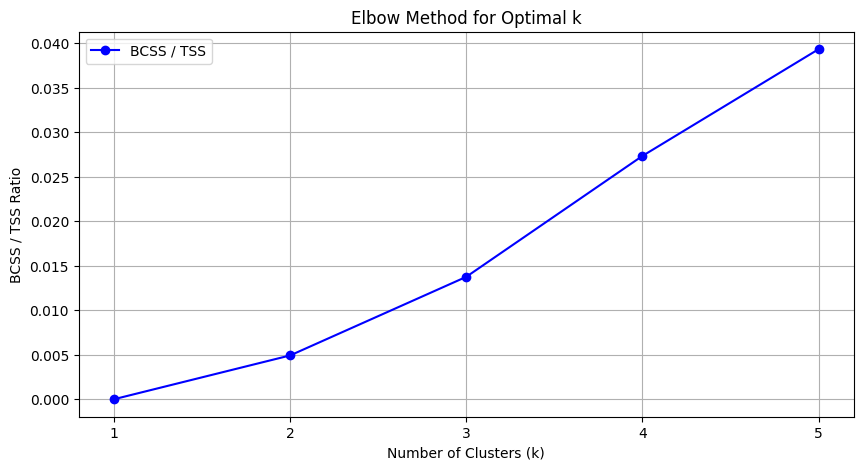

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(k_range, ratio, 'bo-', label='BCSS / TSS')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('BCSS / TSS Ratio')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid()
plt.legend()
plt.show()

In [9]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
data['Cluster'] = clusters

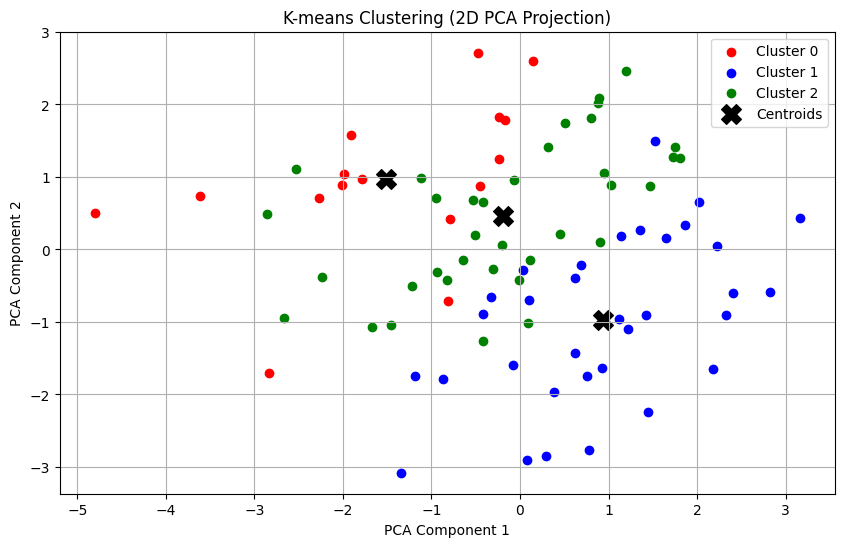

In [10]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green']  # Adjust for k
for i in range(k):
    plt.scatter(X_pca[clusters == i, 0], X_pca[clusters == i, 1], 
                c=colors[i], label=f'Cluster {i}')

# Plot centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            marker='X', s=200, c='black', label='Centroids')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering (2D PCA Projection)')
plt.legend()
plt.grid()
plt.show()

In [11]:
print(data.groupby('Cluster').mean())

           User ID        Age  Daily Work Hours  Daily Leisure Hours  \
Cluster                                                                
0        37.125000  53.312500          7.043750             4.362500   
1        46.727273  30.757576          7.430303             4.712121   
2        42.194444  41.444444          6.636111             3.811111   

         Daily Exercise Minutes  Daily Sleep Hours  Productivity Score  \
Cluster                                                                  
0                     38.562500           6.225000           77.875000   
1                     65.636364           7.630303           87.242424   
2                     75.250000           7.030556           79.444444   

         Screen Time (hours)  Commute Time (hours)  
Cluster                                             
0                   4.806250              1.575000  
1                   6.121212              1.221212  
2                   5.886111              1.922222  


## Use case: Providing time management tips and learning strategies

– About: This use case aims to provide users with suggestions to improve their time management and learning strategies. Before doing so, the system will analyze key learning-related factors that may significantly influence the user's `Productivity Score`.

– Tasks: The following section performs an `MLR-OLS analysis` to identify the most important factors. Based on this analysis, a regression model will be built to predict each user's `Productivity Score`.

In [13]:
# Create dataset
path = "../data/Time Management and Productivity Insights.csv"
data = pd.read_csv(path)

# Select features
features = ['Age', 'Daily Work Hours', 'Daily Leisure Hours', 'Daily Exercise Minutes',
            'Daily Sleep Hours', 'Screen Time (hours)', 'Commute Time (hours)']
X = data[features]
y = data['Productivity Score']

# Prepare Training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1. OLS analysis

In [14]:
X = sm.add_constant(X) # Add intercept
model = sm.OLS(y, X).fit() # Build MLR model
print(model.summary()) # Print result

                            OLS Regression Results                            
Dep. Variable:     Productivity Score   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     11.70
Date:                Thu, 27 Mar 2025   Prob (F-statistic):           4.84e-10
Time:                        15:43:51   Log-Likelihood:                -287.15
No. Observations:                  85   AIC:                             590.3
Df Residuals:                      77   BIC:                             609.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     31

### 2. MLR regression task

In [15]:
# Create and train regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [16]:
# Predict the Productivity Score on testing set
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R_square: {r2:.2f}")

MSE: 135.58
R_square: 0.05


In [17]:
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
})
print(coefficients.sort_values(by='Coefficient', ascending=False))

                  Feature  Coefficient
1        Daily Work Hours     4.063957
2     Daily Leisure Hours     2.692441
4       Daily Sleep Hours     0.967680
5     Screen Time (hours)     0.416873
0                     Age     0.187966
3  Daily Exercise Minutes     0.069181
6    Commute Time (hours)    -4.062709


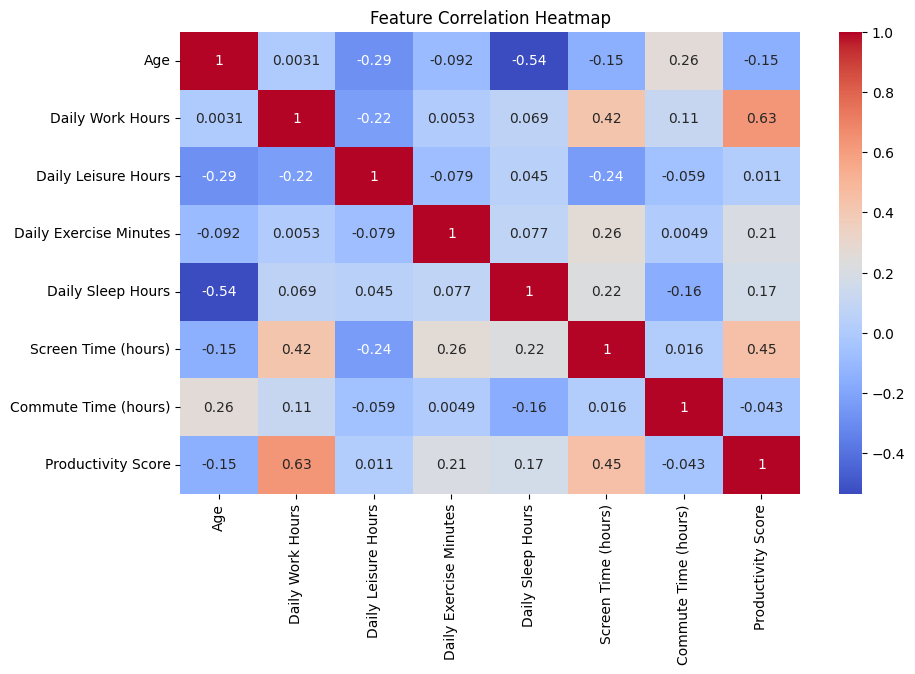

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(data[features + ['Productivity Score']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()